# Overview
This notebook analyses and identifies a mechanism to detect Deepfake videos of people doing/saying fictional things. This is based on [this](https://www.kaggle.com/c/deepfake-detection-challenge/overview) Kaggle competition. 

# Analysis
1. How long are the videos? What is the max video length?
2. Are the videos without sound or audio without a video?
2. How many people appear in the videos? Are there any specific people that appear more than others?
3. What are the actions that happen in the video? Are the actions performed by the people?
4. Can we gather/create a corpus of data that holds the Truth?

In [61]:
!pip install mtcnn
!pip install keras-facenet
#!pip install tensorflow

In [2]:
import json

data_path = "datasets/deepfake-detection-challenge/{}/{}"
train_folder = "train_sample_videos"

def read_metadata(path):
    with open(path) as json_file:
        return json.load(json_file)
    
metadata = read_metadata(data_path.format(train_folder, "metadata.json"))

In [3]:
labels = [v['label'] for k, v in metadata.items()]
fake_items_count = labels.count('FAKE')
real_items_count = labels.count('REAL')
print("There are {} fake videos".format(fake_items_count))
print("There are {} real videos".format(real_items_count))

There are 323 fake videos
There are 77 real videos


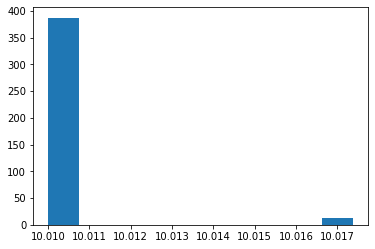

In [9]:
import cv2
import matplotlib.pyplot as plt

def get_duration(videoCapture):  
    fps = videoCapture.get(cv2.CAP_PROP_FPS)
    frame_count = int(videoCapture.get(cv2.CAP_PROP_FRAME_COUNT))
    return frame_count/fps

lengths = []
for md in metadata:
    cap = cv2.VideoCapture(data_path.format(train_folder, md))
    lengths.append(get_duration(cap))

plt.hist(lengths)
plt.show()

## Face Detection & Recognition
In order to figure out how many people appear in these videos, we first need to identify the faces within each video ([MTCNN](https://arxiv.org/abs/1604.02878)). Then, we need a model that recognizes who the people are in the photo. FaceNet is a Deep Learning model for face recognition. [Here](https://arxiv.org/pdf/1503.03832.pdf) is the article that describes FaceNet. 

In [96]:
from mtcnn import MTCNN

detector = MTCNN()

def get_frame_count(cap):
    return int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
def get_faces(md, frames):
    faces = []
    cap = cv2.VideoCapture(data_path.format(train_folder, md))
    slide = int(get_frame_count(cap) / frames)
    for i in range(frames * slide):
        ret = cap.grab()
        if (i % slide == 0):
            ret, img = cap.retrieve()
            frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            faces = faces + get_faces_from_frame(frame)
    cap.release()
    return faces
        
def get_faces_from_frame(frame):
    boxes = detector.detect_faces(frame)
    return list(map(lambda box: extract_face(box, frame), boxes))
    
def extract_face(box, image):
    x, y, width, height = box['box']
    x1, y1 = abs(x), abs(y)
    x2, y2 = x1 + width, y1 + height
    return image[y1:y2, x1:x2]

def get_all_faces(metadata, frames=10):
    faces = []
    index = []
    for md in metadata:
        video_faces = get_faces(md, frames)
        faces = faces + video_faces
        index = index + [md] * len(video_faces)
    return faces, index

faces, index = get_all_faces(metadata)

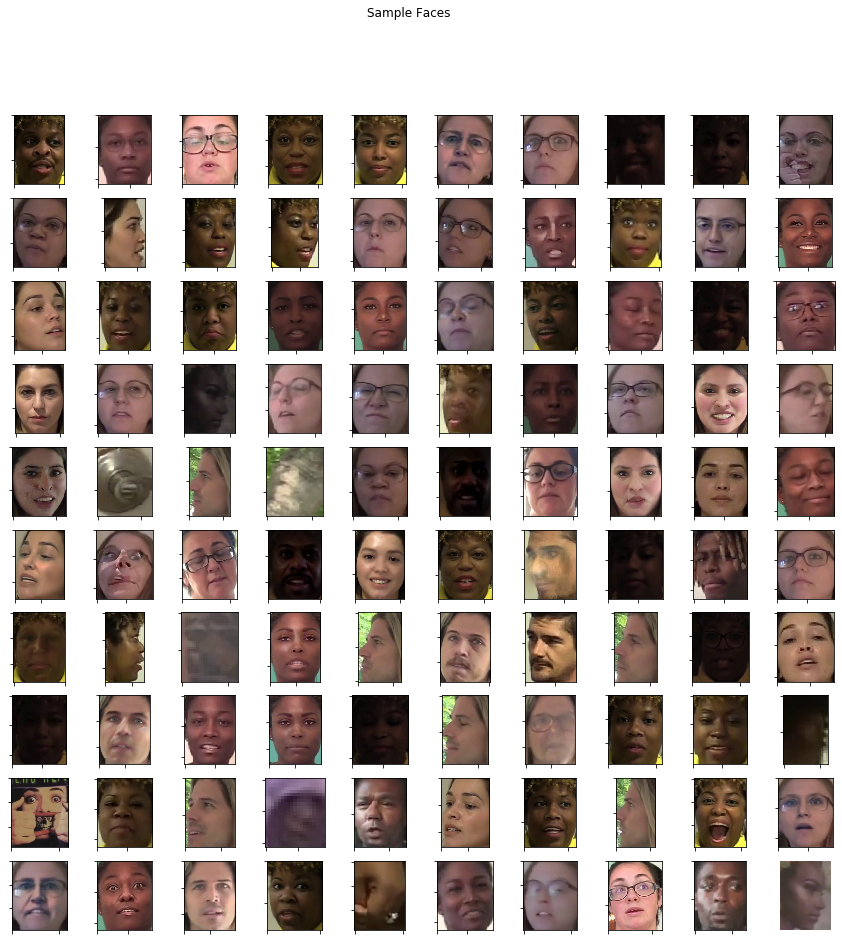

In [120]:
import numpy as np
import matplotlib.pyplot as plt

rows, cols = 10, 10
random_faces = np.random.choice(faces, rows*cols, replace=False)

def display_faces(random_faces, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(15,15))
    fig.suptitle('Sample Faces')
    for i, ax in enumerate(axs.flat):
        ax.imshow(random_faces[i])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.axis("off")
    plt.show()
    
display_faces(random_faces, rows, cols)

In [98]:
from keras_facenet import FaceNet
embedder = FaceNet()
embeddings = embedder.embeddings(faces)

Number of clusters are [4633, 4511, 3178, 916, 248, 176, 130, 105, 84, 70, 56, 44, 36, 30, 25, 22, 18, 16, 15, 14, 13, 12]


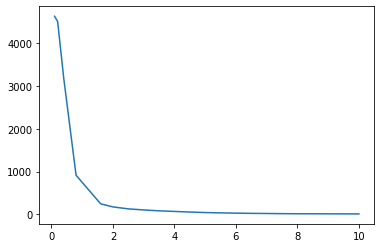

In [117]:
from sklearn.cluster import AgglomerativeClustering

distance_thresholds = [0.1, 0.2, 0.4, 0.8, 1.6, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]
models = []
num_clusters = []
for distance in distance_thresholds:
    aggCluster = AgglomerativeClustering(n_clusters=None, distance_threshold=distance, affinity='euclidean') \
        .fit(embeddings)
    models.append(aggCluster)
    num_clusters.append(aggCluster.n_clusters_)

plt.plot(distance_thresholds, num_clusters)
print("Number of clusters are {}".format(num_clusters))

Number of samples is 183


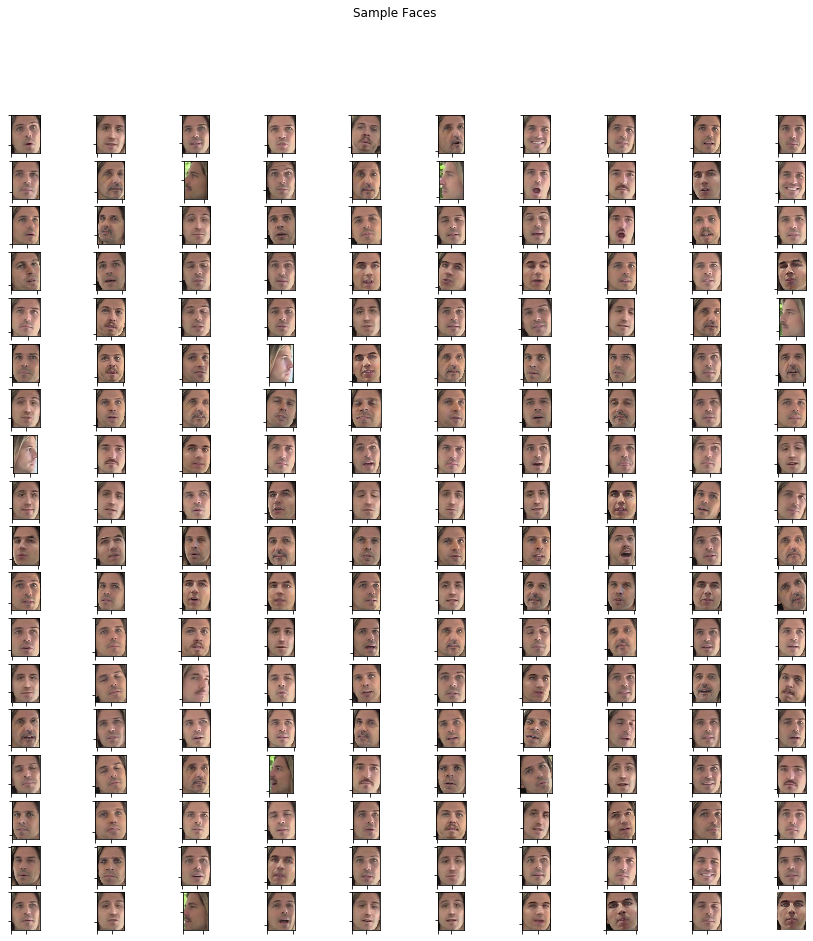

In [161]:
import random

def display_random_clustered_faces(faces, model, cols):
    n_clusters = model.n_clusters_
    label = random.randint(1, n_clusters)
    index = [i for i, x in enumerate(model.labels_) if x == label]
    clustered_faces = [faces[i] for i in index]
    print("Number of samples is {}".format(len(index)))
    rows = int(len(index) / cols)
    random_faces = np.random.choice(clustered_faces, rows*cols, replace=False)
    display_faces(random_faces, rows, cols)
    
display_random_clustered_faces(faces, models[15], 10)

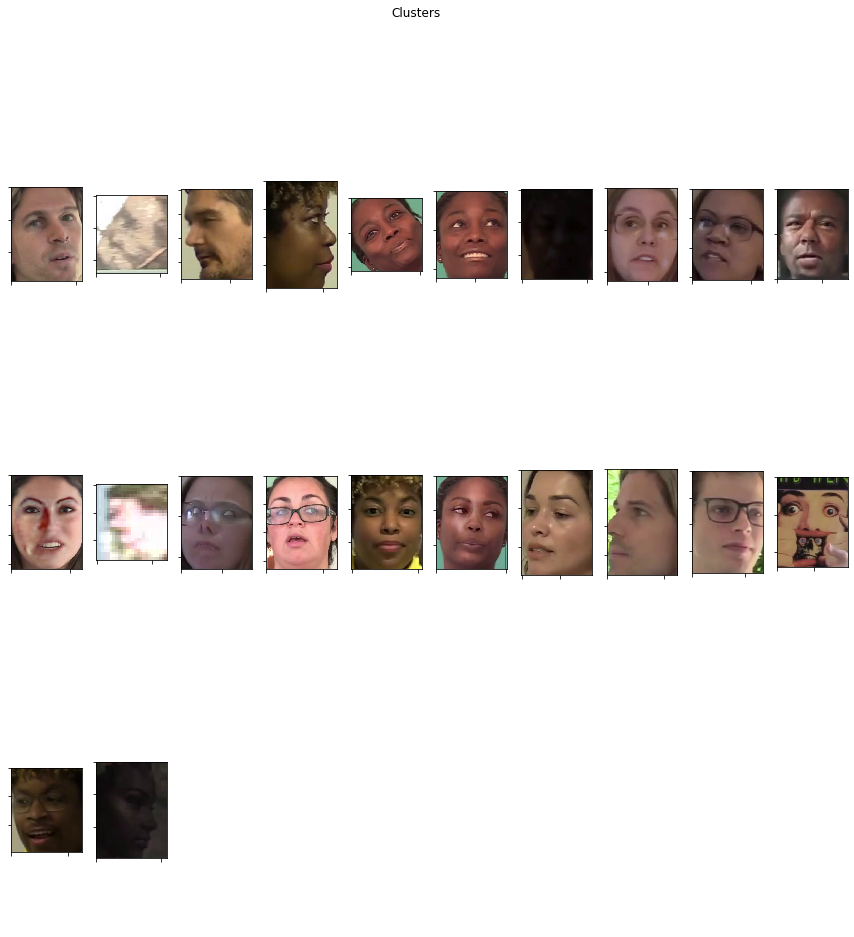

In [165]:
from collections import defaultdict
from math import ceil

def group_faces(faces, model):
    labels = model.labels_
    dict = defaultdict(list)
    for i, l in enumerate(labels):
        dict[l].append(faces[i])
    return dict

def display_all_clusters(faces, model, cols=10):
    group = group_faces(faces, model)
    group_keys = list(group.keys())
    n_clusters = model.n_clusters_
    rows = ceil(n_clusters / cols)
    empty_idx = cols - (rows * cols - n_clusters)
    fig, axs = plt.subplots(rows, cols, figsize=(15,15))
    for ax in axs[-1, empty_idx:]:
        ax.axis('off')
    fig.suptitle('Clusters')
    for i in range(n_clusters):
        ax = axs.flat[i]
        ax.imshow(group[group_keys[i]][0])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.axis("off")
    plt.show()

display_all_clusters(faces, models[15])

In [167]:
from sklearn.neighbors import BallTree

nn = BallTree(embeddings, leaf_size=2)

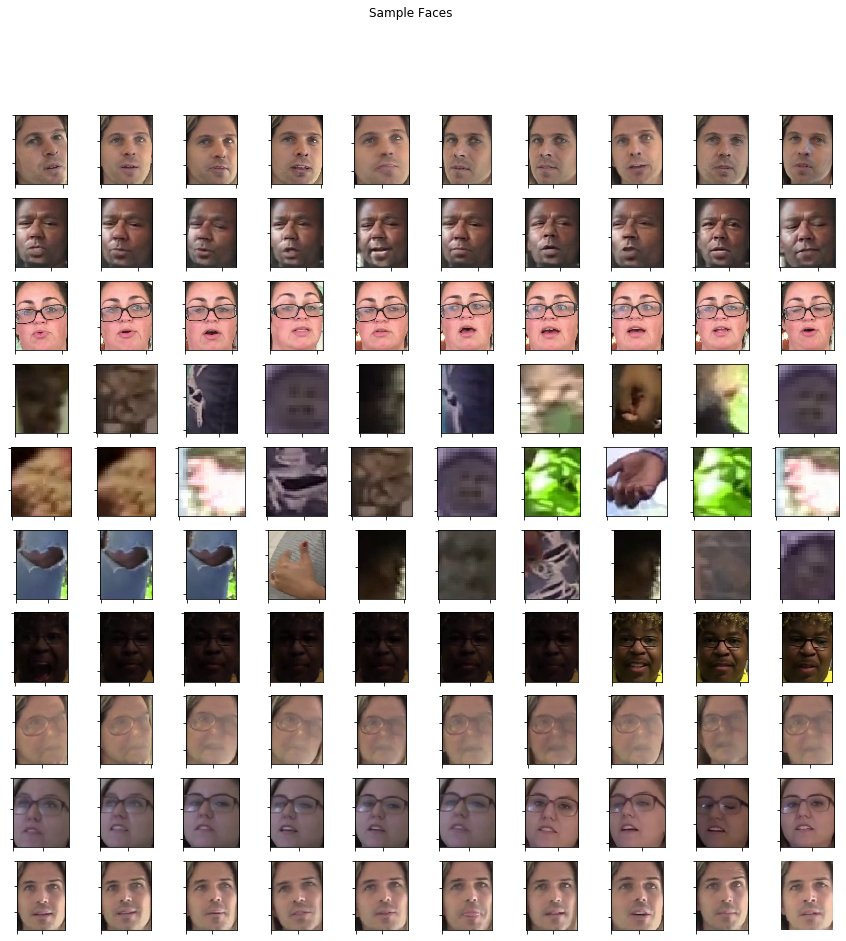

In [190]:
def get_neighbors(indices, embeddings=embeddings, faces=faces, num_neighbors=10):
    neighbors = []
    dist, ind_list = nn.query(embeddings[indices], k=num_neighbors)
    return [faces[i] for neighbor_list in ind_list for i in neighbor_list]

indices = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
neighbors = get_neighbors(indices)
display_faces(neighbors, len(indices) , 10)